In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil

# 1. Define Paths
# Change 'rsna_png_dataset.zip' if your file is named differently
drive_path = "/content/drive/MyDrive/rsna_png_dataset.zip"
local_path = "/content/dataset.zip"
extract_dir = "/content/rsna_png_256"

# 2. Check if file exists in Drive
if os.path.exists(drive_path):
    print(f"✅ Found file on Drive: {drive_path}")

    # 3. Copy to Local VM (This gives you the speed boost)
    print("⏳ Copying to local runtime...")
    shutil.copy(drive_path, local_path)

    # 4. Unzip
    print("⏳ Unzipping...")
    shutil.unpack_archive(local_path, extract_dir)

    print(f"🚀 Success! Data is ready at: {extract_dir}")
else:
    print(f"❌ File not found: {drive_path}")
    print("Double-check the filename in your Google Drive!")

✅ Found file on Drive: /content/drive/MyDrive/rsna_png_dataset.zip
⏳ Copying to local runtime...
⏳ Unzipping...
🚀 Success! Data is ready at: /content/rsna_png_256


In [ ]:
# 1. Install updated libraries compatible with NumPy 2.0 (Default in Colab)
# We avoid downgrading NumPy because it breaks pre-installed system packages (Jax, TF, etc.)
!pip install -U "albumentations>=1.4.0" "scikit-image>=0.23.0" "scipy>=1.13"

# 2. Install segmentation models and dicom libraries
!pip install -q segmentation-models-pytorch pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg

print("✅ Installation Complete. PLEASE RESTART YOUR SESSION NOW via 'Runtime' -> 'Restart Session'.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 105.7 MB/s eta 0:00:00
✅ Installation Complete. PLEASE RESTART YOUR SESSION NOW via 'Runtime' -> 'Restart Session'.


In [ ]:
import os
import shutil
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define Paths
# Replace 'best_mobilenet_rsna.pth' with your actual filename in Drive
drive_model_path = "/content/drive/MyDrive/RSNA_Project/models/best_model_512.pth"
local_model_path = "best_mobilenet_rsna.pth"

# 3. Copy the Model
if os.path.exists(drive_model_path):
    print(f"⏳ Copying model from Drive...")
    shutil.copy(drive_model_path, local_model_path)
    print(f"✅ Success! Model weights are now at: {local_model_path}")
else:
    print(f"❌ Error: File not found at {drive_model_path}")
    print("Check the filename in your Google Drive.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
⏳ Copying model from Drive...
✅ Success! Model weights are now at: best_mobilenet_rsna.pth


In [ ]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
import albumentations as A
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from google.colab import drive
import warnings

# Optimize for A100
torch.backends.cudnn.benchmark = True
cv2.setNumThreads(0)
warnings.filterwarnings("ignore")

# ==========================================
# 0. GOOGLE DRIVE SETUP
# ==========================================
drive.mount('/content/drive')
SAVE_PATH = "/content/drive/MyDrive/RSNA_Project/models"
os.makedirs(SAVE_PATH, exist_ok=True)

# ==========================================
# 1. CONFIGURATION (512px OPTIMIZED)
# ==========================================
CONFIG = {
    # Ensure these paths match your actual 512px data folders
    "IMG_DIR": "rsna_png_256/images",
    "MASK_DIR": "rsna_png_256/masks",

    "IMG_SIZE": 512,         # High Res
    "NUM_CLASSES": 6,

    # --- MEMORY OPTIMIZATION ---
    "REAL_BATCH_SIZE": 32,   # Safe for A100 VRAM @ 512px
    "VIRTUAL_BATCH_SIZE": 512, # Target for stability

    "LR": 1e-3,              # Slightly lower LR for high-res stability
    "EPOCHS": 30,            # Fits in ~2.5 Hours
    "DEVICE": "cuda",
    "NUM_WORKERS": 16,       # High IO for large images
}

# Calculate accumulation steps (512 / 32 = 16 steps)
CONFIG["ACCUM_STEPS"] = CONFIG["VIRTUAL_BATCH_SIZE"] // CONFIG["REAL_BATCH_SIZE"]

# ==========================================
# 2. FAST DATASET
# ==========================================
class FastPNGDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self): return len(self.image_paths)

    def __getitem__(self, idx):
        # Read as grayscale to save IO, then stack
        img = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        # Stack to 3 channels for ImageNet backbone compatibility
        img = np.stack([img, img, img], axis=-1)

        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img, mask = aug['image'], aug['mask']

        # HWC -> CHW, Normalize 0-1
        img = img.transpose(2, 0, 1).astype(np.float32) / 255.0
        return torch.from_numpy(img), torch.from_numpy(mask).long()

# Load Data
print("⏳ Preparing Data (Using ALL samples)...")
all_images = sorted([os.path.join(CONFIG['IMG_DIR'], f) for f in os.listdir(CONFIG['IMG_DIR'])])
all_masks = sorted([os.path.join(CONFIG['MASK_DIR'], f) for f in os.listdir(CONFIG['MASK_DIR'])])

# Split
train_imgs, valid_imgs, train_masks, valid_masks = train_test_split(
    all_images, all_masks, test_size=0.1, random_state=42
)
print(f"📊 Train: {len(train_imgs)} | Valid: {len(valid_imgs)}")

# ==========================================
# 3. TRANSFORMS & LOADERS
# ==========================================
train_transforms = A.Compose([
    A.Resize(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.2), # Larger holes for 512px
])
valid_transforms = A.Compose([
    A.Resize(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']),
])

train_ds = FastPNGDataset(train_imgs, train_masks, transform=train_transforms)
valid_ds = FastPNGDataset(valid_imgs, valid_masks, transform=valid_transforms)

train_loader = DataLoader(train_ds, batch_size=CONFIG['REAL_BATCH_SIZE'], shuffle=True, num_workers=CONFIG['NUM_WORKERS'], pin_memory=True)
valid_loader = DataLoader(valid_ds, batch_size=CONFIG['REAL_BATCH_SIZE'], shuffle=False, num_workers=CONFIG['NUM_WORKERS'], pin_memory=True)

# ==========================================
# 4. METRICS & LOSS
# ==========================================
def calculate_metrics(pred_logits, target_mask):
    """Calculates Pixel Accuracy & Dice approximation"""
    pred_probs = torch.softmax(pred_logits, dim=1)
    pred_labels = torch.argmax(pred_probs, dim=1)

    # Pixel Accuracy
    correct = (pred_labels == target_mask).sum().item()
    total = torch.numel(target_mask)
    return correct / total

# Loss: Dice + Focal
dice_loss = smp.losses.DiceLoss(mode='multiclass', from_logits=True)
focal_loss = smp.losses.FocalLoss(mode='multiclass')
criterion = lambda p, t: 0.5 * dice_loss(p, t) + 0.5 * focal_loss(p, t)

# ==========================================
# 5. MODEL & TRAINING LOOP
# ==========================================
print(f"🏗️ Building MobileNetV3 (Input: {CONFIG['IMG_SIZE']}x{CONFIG['IMG_SIZE']})...")
model = smp.Unet(
    encoder_name="timm-mobilenetv3_large_100",
    encoder_weights="imagenet",
    in_channels=3,
    classes=CONFIG["NUM_CLASSES"],
)
model.to(CONFIG['DEVICE'])

optimizer = optim.AdamW(model.parameters(), lr=CONFIG['LR'])
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG['EPOCHS'])
scaler = GradScaler()

history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}
best_valid_loss = float("inf")

print(f"🔥 Starting Training for {CONFIG['EPOCHS']} epochs (approx 2.5 hours)...")

for epoch in range(CONFIG['EPOCHS']):
    model.train()
    train_loss_accum = 0
    train_acc_accum = 0

    # --- TRAIN ---
    pbar = tqdm(train_loader, desc=f"Ep {epoch+1}/{CONFIG['EPOCHS']}", leave=False)
    optimizer.zero_grad()

    for i, (images, masks) in enumerate(pbar):
        images, masks = images.to(CONFIG['DEVICE']), masks.to(CONFIG['DEVICE'])

        with autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, masks)
            # Normalize loss for Gradient Accumulation
            loss = loss / CONFIG["ACCUM_STEPS"]

        scaler.scale(loss).backward()

        if (i + 1) % CONFIG["ACCUM_STEPS"] == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        # Track raw loss/acc (undo normalization for display)
        train_loss_accum += loss.item() * CONFIG["ACCUM_STEPS"]
        train_acc_accum += calculate_metrics(outputs, masks)

    # --- VALIDATION ---
    model.eval()
    valid_loss_accum = 0
    valid_acc_accum = 0

    # AUC Storage (Last epoch only)
    all_preds, all_targets = [], []

    with torch.no_grad():
        for images, masks in valid_loader:
            images, masks = images.to(CONFIG['DEVICE']), masks.to(CONFIG['DEVICE'])
            with autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, masks)

            valid_loss_accum += loss.item()
            valid_acc_accum += calculate_metrics(outputs, masks)

            if epoch == CONFIG['EPOCHS'] - 1:
                all_preds.append(torch.softmax(outputs, dim=1).cpu().numpy())
                all_targets.append(masks.cpu().numpy())

    scheduler.step()

    # Averages
    avg_train_loss = train_loss_accum / len(train_loader)
    avg_valid_loss = valid_loss_accum / len(valid_loader)
    avg_valid_acc = valid_acc_accum / len(valid_loader)

    history['train_loss'].append(avg_train_loss)
    history['valid_loss'].append(avg_valid_loss)
    history['train_acc'].append(train_acc_accum / len(train_loader))
    history['valid_acc'].append(avg_valid_acc)

    print(f"✅ Ep {epoch+1}: TrLoss {avg_train_loss:.4f} | ValLoss {avg_valid_loss:.4f} | ValAcc {avg_valid_acc:.4f}")

    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        torch.save(model.state_dict(), f"{SAVE_PATH}/best_model_512.pth")
        print(f"   💾 Saved Best Model (Loss: {best_valid_loss:.4f})")

# ==========================================
# 6. PLOTS & AUC
# ==========================================
# Loss Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['valid_loss'], label='Valid')
plt.title('Loss (Lower is Better)')
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['valid_acc'], label='Valid')
plt.title('Pixel Accuracy (Higher is Better)')
plt.legend()
plt.savefig(f"{SAVE_PATH}/training_metrics_512.png")
plt.show()

# AUC-ROC
print("📊 Calculating Final AUC-ROC...")
if all_preds:
    y_pred = np.concatenate(all_preds, axis=0)
    y_true = np.concatenate(all_targets, axis=0)

    N, C, H, W = y_pred.shape
    # Sample pixels to save RAM (1 in 100 pixels)
    y_pred_flat = y_pred.transpose(0, 2, 3, 1).reshape(-1, C)[::100]
    y_true_flat = y_true.reshape(-1)[::100]

    y_true_bin = label_binarize(y_true_flat, classes=range(C))

    plt.figure(figsize=(10, 8))
    for i in range(C):
        if np.sum(y_true_bin[:, i]) > 0: # Only plot present classes
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_flat[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'Class {i} (AUC={roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('Multi-class AUC-ROC')
    plt.legend()
    plt.savefig(f"{SAVE_PATH}/auc_curve_512.png")
    plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
⏳ Preparing Data (Using ALL samples)...
📊 Train: 55812 | Valid: 6202
🏗️ Building MobileNetV3 (Input: 512x512)...


🔥 Starting Training for 30 epochs (approx 2.5 hours)...


Ep 1/30:   0%|          | 0/1745 [00:00<?, ?it/s]

✅ Ep 1: TrLoss 0.4958 | ValLoss 0.4087 | ValAcc 0.9331
   💾 Saved Best Model (Loss: 0.4087)


Ep 2/30:   0%|          | 0/1745 [00:00<?, ?it/s]

✅ Ep 2: TrLoss 0.3763 | ValLoss 0.3392 | ValAcc 0.9542
   💾 Saved Best Model (Loss: 0.3392)


Ep 3/30:   0%|          | 0/1745 [00:00<?, ?it/s]

✅ Ep 3: TrLoss 0.3263 | ValLoss 0.2846 | ValAcc 0.9582
   💾 Saved Best Model (Loss: 0.2846)


Ep 4/30:   0%|          | 0/1745 [00:00<?, ?it/s]

✅ Ep 4: TrLoss 0.2623 | ValLoss 0.2183 | ValAcc 0.9618
   💾 Saved Best Model (Loss: 0.2183)


Ep 5/30:   0%|          | 0/1745 [00:00<?, ?it/s]

✅ Ep 5: TrLoss 0.1942 | ValLoss 0.1611 | ValAcc 0.9640
   💾 Saved Best Model (Loss: 0.1611)


Ep 6/30:   0%|          | 0/1745 [00:00<?, ?it/s]

✅ Ep 6: TrLoss 0.1550 | ValLoss 0.1374 | ValAcc 0.9693
   💾 Saved Best Model (Loss: 0.1374)


Ep 7/30:   0%|          | 0/1745 [00:00<?, ?it/s]

✅ Ep 7: TrLoss 0.1395 | ValLoss 0.1266 | ValAcc 0.9709
   💾 Saved Best Model (Loss: 0.1266)


Ep 8/30:   0%|          | 0/1745 [00:00<?, ?it/s]

✅ Ep 8: TrLoss 0.1285 | ValLoss 0.1173 | ValAcc 0.9720
   💾 Saved Best Model (Loss: 0.1173)


Ep 9/30:   0%|          | 0/1745 [00:00<?, ?it/s]

✅ Ep 9: TrLoss 0.1193 | ValLoss 0.1109 | ValAcc 0.9735
   💾 Saved Best Model (Loss: 0.1109)


Ep 10/30:   0%|          | 0/1745 [00:00<?, ?it/s]

✅ Ep 10: TrLoss 0.1132 | ValLoss 0.1044 | ValAcc 0.9735
   💾 Saved Best Model (Loss: 0.1044)


Ep 11/30:   0%|          | 0/1745 [00:00<?, ?it/s]

✅ Ep 11: TrLoss 0.1079 | ValLoss 0.0993 | ValAcc 0.9762
   💾 Saved Best Model (Loss: 0.0993)


Ep 12/30:   0%|          | 0/1745 [00:00<?, ?it/s]

✅ Ep 12: TrLoss 0.1032 | ValLoss 0.0966 | ValAcc 0.9762
   💾 Saved Best Model (Loss: 0.0966)


Ep 13/30:   0%|          | 0/1745 [00:00<?, ?it/s]

✅ Ep 13: TrLoss 0.0993 | ValLoss 0.0918 | ValAcc 0.9775
   💾 Saved Best Model (Loss: 0.0918)


Ep 14/30:   0%|          | 0/1745 [00:00<?, ?it/s]

✅ Ep 14: TrLoss 0.0958 | ValLoss 0.0885 | ValAcc 0.9782
   💾 Saved Best Model (Loss: 0.0885)


Ep 15/30:   0%|          | 0/1745 [00:00<?, ?it/s]

✅ Ep 15: TrLoss 0.0926 | ValLoss 0.0867 | ValAcc 0.9789
   💾 Saved Best Model (Loss: 0.0867)


Ep 16/30:   0%|          | 0/1745 [00:00<?, ?it/s]

✅ Ep 16: TrLoss 0.0896 | ValLoss 0.0828 | ValAcc 0.9794
   💾 Saved Best Model (Loss: 0.0828)


Ep 17/30:   0%|          | 0/1745 [00:00<?, ?it/s]

✅ Ep 17: TrLoss 0.0873 | ValLoss 0.0807 | ValAcc 0.9798
   💾 Saved Best Model (Loss: 0.0807)


Ep 18/30:   0%|          | 0/1745 [00:00<?, ?it/s]

✅ Ep 18: TrLoss 0.0848 | ValLoss 0.0800 | ValAcc 0.9803
   💾 Saved Best Model (Loss: 0.0800)


Ep 19/30:   0%|          | 0/1745 [00:00<?, ?it/s]

✅ Ep 19: TrLoss 0.0838 | ValLoss 0.0777 | ValAcc 0.9808
   💾 Saved Best Model (Loss: 0.0777)


Ep 20/30:   0%|          | 0/1745 [00:00<?, ?it/s]

✅ Ep 20: TrLoss 0.0814 | ValLoss 0.0754 | ValAcc 0.9817
   💾 Saved Best Model (Loss: 0.0754)


Ep 21/30:   0%|          | 0/1745 [00:00<?, ?it/s]

✅ Ep 21: TrLoss 0.0795 | ValLoss 0.0735 | ValAcc 0.9817
   💾 Saved Best Model (Loss: 0.0735)


Ep 22/30:   0%|          | 0/1745 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Resuming Training.


In [ ]:
import os
import shutil
import cv2
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
import albumentations as A
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from google.colab import drive
import warnings

# Optimizations
cv2.setNumThreads(0)
warnings.filterwarnings("ignore")

# ==========================================
# 1. MOUNT DRIVE & PREPARE DATA
# ==========================================
print("🔗 Mounting Google Drive...")
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Configuration
CONFIG = {
    "DRIVE_ZIP": "/content/drive/MyDrive/rsna_png_fast.zip",
    "DRIVE_MODEL": "/content/drive/MyDrive/RSNA_Project/models/best_model_512.pth", # Previous best model
    "SAVE_PATH": "/content/drive/MyDrive/best_mobilenet_rsna_refined.pth", # Where to save new result

    "IMG_DIR": "/content/rsna_png_256/images",
    "MASK_DIR": "/content/rsna_png_256/masks",

    "IMG_SIZE": 512,
    "BATCH_SIZE": 64,    # Keep consistent with previous run
    "LR": 5e-5,          # Low LR for Fine-Tuning
    "EPOCHS": 10,        # Number of additional epochs
    "DEVICE": "cuda",
    "NUM_WORKERS": 16
}

# Copy Dataset if not present
if not os.path.exists(CONFIG['IMG_DIR']):
    print(f"⏳ Copying dataset from Drive...")
    shutil.copy(CONFIG['DRIVE_ZIP'], "/content/dataset.zip")
    print("⏳ Unzipping...")
    shutil.unpack_archive("/content/dataset.zip", "/content/rsna_png_256")
    print("✅ Dataset Ready.")
else:
    print("✅ Dataset already loaded.")

# Copy Model Weights if not present locally
LOCAL_WEIGHTS = "previous_weights.pth"
if not os.path.exists(LOCAL_WEIGHTS):
    if os.path.exists(CONFIG['DRIVE_MODEL']):
        print(f"⏳ Copying previous model weights...")
        shutil.copy(CONFIG['DRIVE_MODEL'], LOCAL_WEIGHTS)
        print("✅ Weights Ready.")
    else:
        print(f"⚠️ Warning: Could not find {CONFIG['DRIVE_MODEL']} on Drive.")

# ==========================================
# 2. DATASET & LOADERS
# ==========================================
class FastPNGDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
    def __len__(self): return len(self.image_paths)
    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        img = np.stack([img, img, img], axis=-1)
        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img, mask = aug['image'], aug['mask']
        img = img.transpose(2, 0, 1).astype(np.float32) / 255.0
        return torch.from_numpy(img), torch.from_numpy(mask).long()

# Prepare Lists
all_images = sorted([os.path.join(CONFIG['IMG_DIR'], f) for f in os.listdir(CONFIG['IMG_DIR'])])
all_masks = sorted([os.path.join(CONFIG['MASK_DIR'], f) for f in os.listdir(CONFIG['MASK_DIR'])])

train_imgs, valid_imgs, train_masks, valid_masks = train_test_split(all_images, all_masks, test_size=0.1, random_state=42)

# Augmentations
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.GridDistortion(p=0.3),
    A.CoarseDropout(num_holes_range=(1, 8), hole_height_range=(10, 20), hole_width_range=(10, 20), p=0.2),
])

train_ds = FastPNGDataset(train_imgs, train_masks, transform=train_transforms)
valid_ds = FastPNGDataset(valid_imgs, valid_masks, transform=None)

train_loader = DataLoader(train_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=True, num_workers=CONFIG['NUM_WORKERS'], pin_memory=True)
valid_loader = DataLoader(valid_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=CONFIG['NUM_WORKERS'], pin_memory=True)

# ==========================================
# 3. LOAD MODEL & RESUME
# ==========================================
print("🏗️ Re-building MobileNetV3-UNet...")
model = smp.Unet(
    encoder_name="timm-mobilenetv3_large_100",
    encoder_weights=None,
    in_channels=3,
    classes=6,
    decoder_use_batchnorm=True
)

# Load State Dict
if os.path.exists(LOCAL_WEIGHTS):
    print(f"🔄 Loading weights from {LOCAL_WEIGHTS}...")
    state_dict = torch.load(LOCAL_WEIGHTS, map_location=CONFIG['DEVICE'])
    # Fix DataParallel keys
    new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    model.load_state_dict(new_state_dict)
    print("✅ Model Restored!")
else:
    print("⚠️ No weights found. Starting from scratch (Random Init).")

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model.to(CONFIG['DEVICE'])

# ==========================================
# 4. TRAINING LOOP (With Drive Save)
# ==========================================
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['LR'])
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG['EPOCHS'])
scaler = GradScaler('cuda')
dice_loss = smp.losses.DiceLoss(mode='multiclass', from_logits=True)
focal_loss = smp.losses.FocalLoss(mode='multiclass')
def criterion(pred, target): return 0.5 * dice_loss(pred, target) + 0.5 * focal_loss(pred, target)

print(f"🔥 Starting Fine-Tuning for {CONFIG['EPOCHS']} epochs...")
best_loss = float("inf")

for epoch in range(CONFIG['EPOCHS']):
    model.train()
    train_loss = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['EPOCHS']}")
    for images, masks in pbar:
        images, masks = images.to(CONFIG['DEVICE'], non_blocking=True), masks.to(CONFIG['DEVICE'], non_blocking=True)

        optimizer.zero_grad()
        with autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        pbar.set_postfix({"Loss": f"{loss.item():.4f}"})

    # Validation
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for images, masks in valid_loader:
            images, masks = images.to(CONFIG['DEVICE'], non_blocking=True), masks.to(CONFIG['DEVICE'], non_blocking=True)
            with autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, masks)
            valid_loss += loss.item()

    scheduler.step()
    avg_valid = valid_loss / len(valid_loader)
    print(f"✅ Epoch {epoch+1} Valid Loss: {avg_valid:.4f}")

    # Save to Drive if improved
    if avg_valid < best_loss:
        best_loss = avg_valid

        # 1. Save Locally
        temp_name = "temp_best.pth"
        state_dict = model.module.state_dict() if hasattr(model, 'module') else model.state_dict()
        torch.save(state_dict, temp_name)

        # 2. Copy to Drive
        try:
            shutil.copy(temp_name, CONFIG['SAVE_PATH'])
            print(f"   💾 Saved to Drive: {CONFIG['SAVE_PATH']}")
        except Exception as e:
            print(f"   ⚠️ Saved locally, but Drive upload failed: {e}")

print("🎉 Training Complete!")

🔗 Mounting Google Drive...
✅ Dataset already loaded.
⏳ Copying previous model weights...
✅ Weights Ready.
🏗️ Re-building MobileNetV3-UNet...
🔄 Loading weights from previous_weights.pth...
✅ Model Restored!
🔥 Starting Fine-Tuning for 10 epochs...


Epoch 1/10:   0%|          | 0/873 [00:00<?, ?it/s]

✅ Epoch 1 Valid Loss: 0.1962
   💾 Saved to Drive: /content/drive/MyDrive/best_mobilenet_rsna_refined.pth


Epoch 2/10:   0%|          | 0/873 [00:00<?, ?it/s]

✅ Epoch 2 Valid Loss: 0.1583
   💾 Saved to Drive: /content/drive/MyDrive/best_mobilenet_rsna_refined.pth


Epoch 3/10:   0%|          | 0/873 [00:00<?, ?it/s]

✅ Epoch 3 Valid Loss: 0.1436
   💾 Saved to Drive: /content/drive/MyDrive/best_mobilenet_rsna_refined.pth


Epoch 4/10:   0%|          | 0/873 [00:00<?, ?it/s]

✅ Epoch 4 Valid Loss: 0.1327
   💾 Saved to Drive: /content/drive/MyDrive/best_mobilenet_rsna_refined.pth


Epoch 5/10:   0%|          | 0/873 [00:00<?, ?it/s]

✅ Epoch 5 Valid Loss: 0.1282
   💾 Saved to Drive: /content/drive/MyDrive/best_mobilenet_rsna_refined.pth


Epoch 6/10:   0%|          | 0/873 [00:00<?, ?it/s]

✅ Epoch 6 Valid Loss: 0.1238
   💾 Saved to Drive: /content/drive/MyDrive/best_mobilenet_rsna_refined.pth


Epoch 7/10:   0%|          | 0/873 [00:00<?, ?it/s]

✅ Epoch 7 Valid Loss: 0.1217
   💾 Saved to Drive: /content/drive/MyDrive/best_mobilenet_rsna_refined.pth


Epoch 8/10:   0%|          | 0/873 [00:00<?, ?it/s]

✅ Epoch 8 Valid Loss: 0.1191
   💾 Saved to Drive: /content/drive/MyDrive/best_mobilenet_rsna_refined.pth


Epoch 9/10:   0%|          | 0/873 [00:00<?, ?it/s]

✅ Epoch 9 Valid Loss: 0.1180
   💾 Saved to Drive: /content/drive/MyDrive/best_mobilenet_rsna_refined.pth


Epoch 10/10:   0%|          | 0/873 [00:00<?, ?it/s]

✅ Epoch 10 Valid Loss: 0.1176
   💾 Saved to Drive: /content/drive/MyDrive/best_mobilenet_rsna_refined.pth
🎉 Training Complete!


# Step 1: Setup & Evaluation Functions

In [ ]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os

# ==========================================
# 1. CONFIGURATION
# ==========================================
EVAL_CONFIG = {
    "MODEL_PATH": "best_mobilenet_rsna_refined.pth", # Or 'best_mobilenet_rsna.pth'
    "DEVICE": "cuda",
    "NUM_CLASSES": 6, # 0=Back, 1=Liver, 2=Spleen, 3=L-Kidney, 4=R-Kidney, 5=Bowel
    "ORGAN_NAMES": ["Background", "Liver", "Spleen", "Left Kidney", "Right Kidney", "Bowel"]
}

# ==========================================
# 2. METRIC CALCULATOR (Dice & IoU)
# ==========================================
def calculate_metrics(pred_mask, true_mask, num_classes):
    """Calculates Dice and IoU per class."""
    dice_scores = []
    iou_scores = []

    # Flatten masks
    pred_mask = pred_mask.view(-1)
    true_mask = true_mask.view(-1)

    for cls in range(1, num_classes): # Skip background (class 0)
        p = (pred_mask == cls)
        t = (true_mask == cls)

        intersection = (p & t).float().sum()
        union = (p | t).float().sum()

        # Dice: 2*Int / (Sum + Sum)
        dice = (2.0 * intersection) / (p.float().sum() + t.float().sum() + 1e-8)
        # IoU: Int / Union
        iou = (intersection) / (union + 1e-8)

        dice_scores.append(dice.item())
        iou_scores.append(iou.item())

    return dice_scores, iou_scores

# ==========================================
# 3. LOAD MODEL
# ==========================================
print("🏗️ Loading Model...")
model = smp.Unet(
    encoder_name="timm-mobilenetv3_large_100",
    encoder_weights=None,
    in_channels=3,
    classes=6
)

if os.path.exists(EVAL_CONFIG['MODEL_PATH']):
    state_dict = torch.load(EVAL_CONFIG['MODEL_PATH'], map_location=EVAL_CONFIG['DEVICE'])
    # Clean keys if saved with DataParallel
    state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    model.load_state_dict(state_dict)
    model.to(EVAL_CONFIG['DEVICE'])
    model.eval()
    print("✅ Model loaded successfully!")
else:
    raise FileNotFoundError(f"❌ Weights not found at {EVAL_CONFIG['MODEL_PATH']}")

🏗️ Loading Model...
✅ Model loaded successfully!


# Step 2: Run Evaluation (Get the Numbers)

In [ ]:
print(f"📊 Starting Evaluation on {len(valid_loader)} batches...")

total_dice = np.zeros(EVAL_CONFIG['NUM_CLASSES'] - 1)
total_iou = np.zeros(EVAL_CONFIG['NUM_CLASSES'] - 1)
n_batches = 0

with torch.no_grad():
    for images, masks in tqdm(valid_loader, desc="Evaluating"):
        images = images.to(EVAL_CONFIG['DEVICE'])
        masks = masks.to(EVAL_CONFIG['DEVICE'])

        # Predict
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1) # Convert logits to class IDs

        # Calculate metrics for this batch
        # We iterate sample by sample to be accurate
        for i in range(len(images)):
            d, iou = calculate_metrics(preds[i], masks[i], EVAL_CONFIG['NUM_CLASSES'])
            total_dice += d
            total_iou += iou
            n_batches += 1

# Average across all samples
avg_dice = total_dice / n_batches
avg_iou = total_iou / n_batches

print("\n🏆 --- FINAL RESULTS ---")
print(f"{'ORGAN':<15} | {'DICE SCORE':<10} | {'IoU SCORE':<10}")
print("-" * 40)
for i, name in enumerate(EVAL_CONFIG['ORGAN_NAMES'][1:]): # Skip background
    print(f"{name:<15} | {avg_dice[i]:.4f}     | {avg_iou[i]:.4f}")
print("-" * 40)
print(f"MEAN DICE: {np.mean(avg_dice):.4f}")
print(f"MEAN IoU:  {np.mean(avg_iou):.4f}")

📊 Starting Evaluation on 97 batches...


Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]


🏆 --- FINAL RESULTS ---
ORGAN           | DICE SCORE | IoU SCORE 
----------------------------------------
Liver           | 0.2534     | 0.2093
Spleen          | 0.1322     | 0.1052
Left Kidney     | 0.1262     | 0.0970
Right Kidney    | 0.1132     | 0.0875
Bowel           | 0.3628     | 0.2652
----------------------------------------
MEAN DICE: 0.1975
MEAN IoU:  0.1528


# Step 3: Visualization (See the Images)

🔎 Visualizing 5 random validation samples...


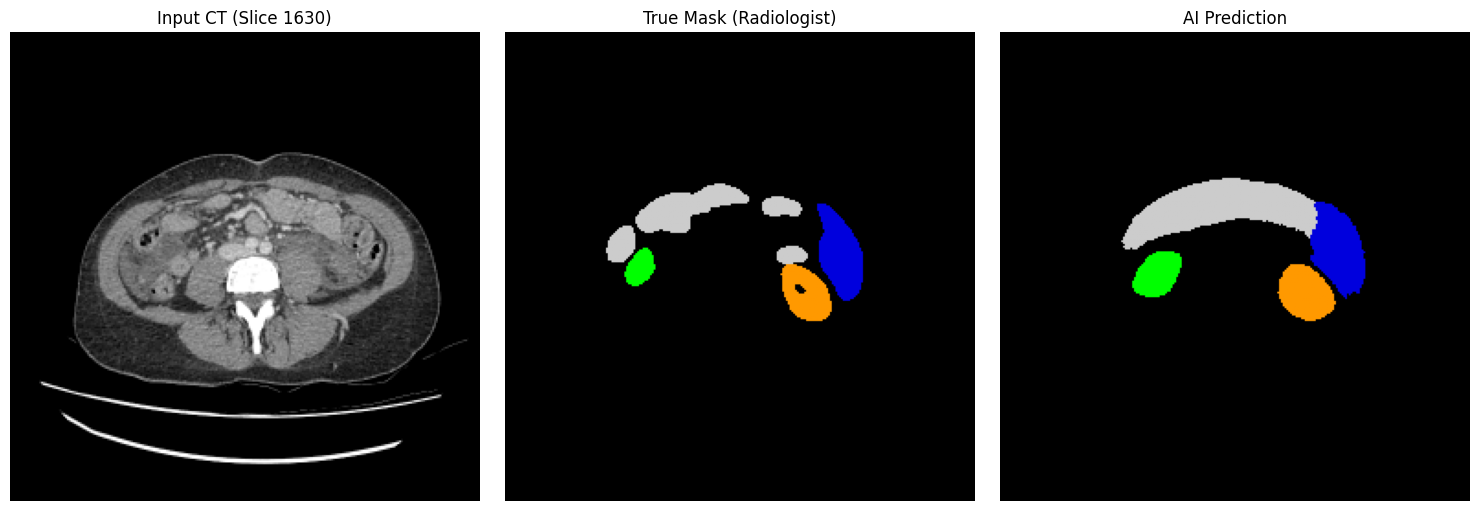

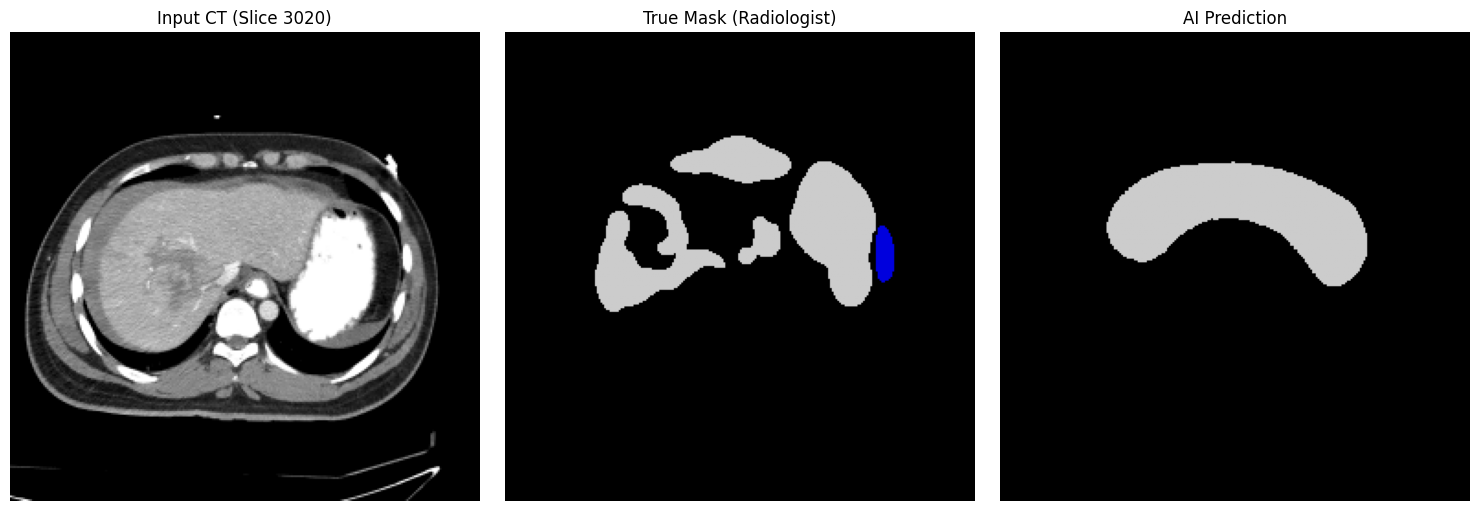

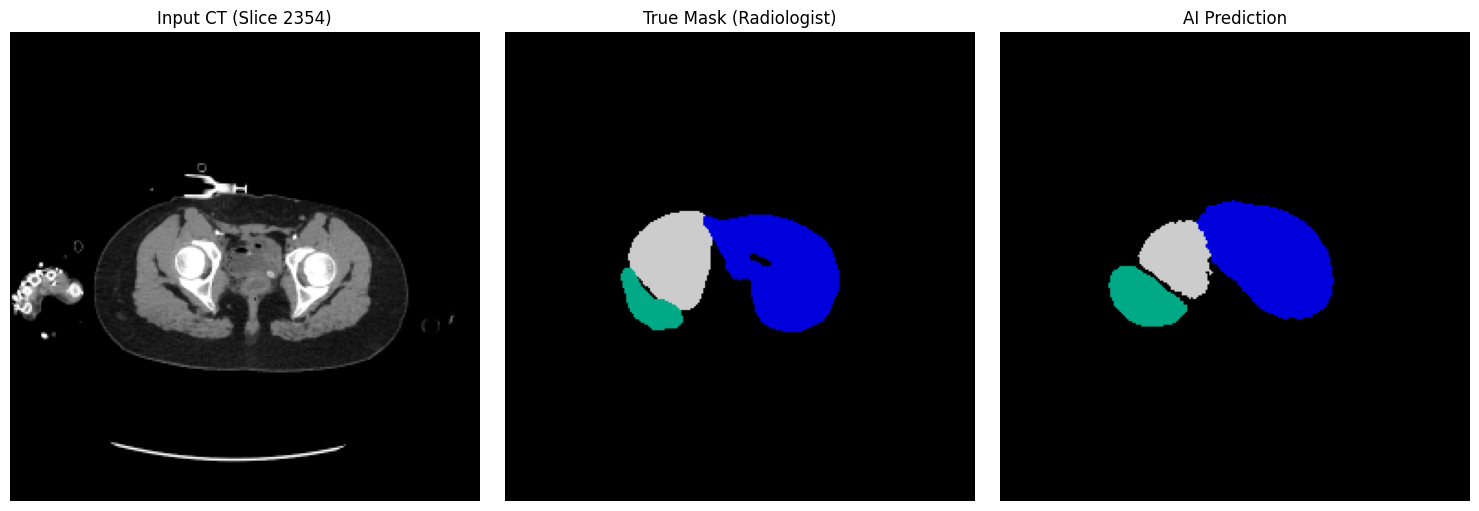

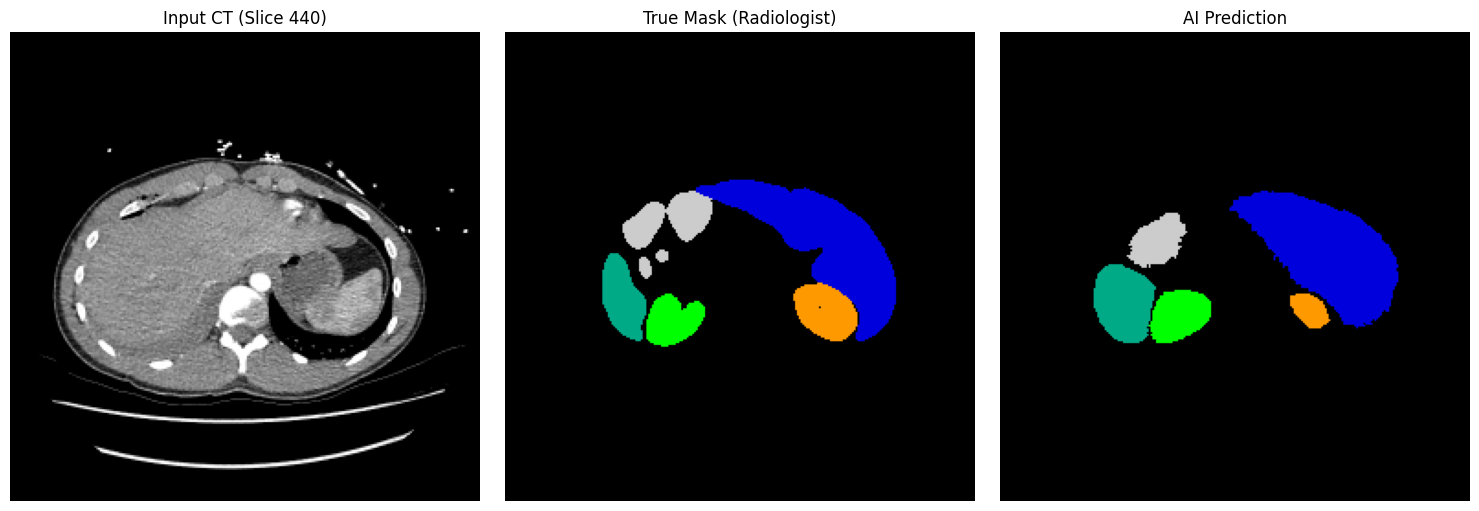

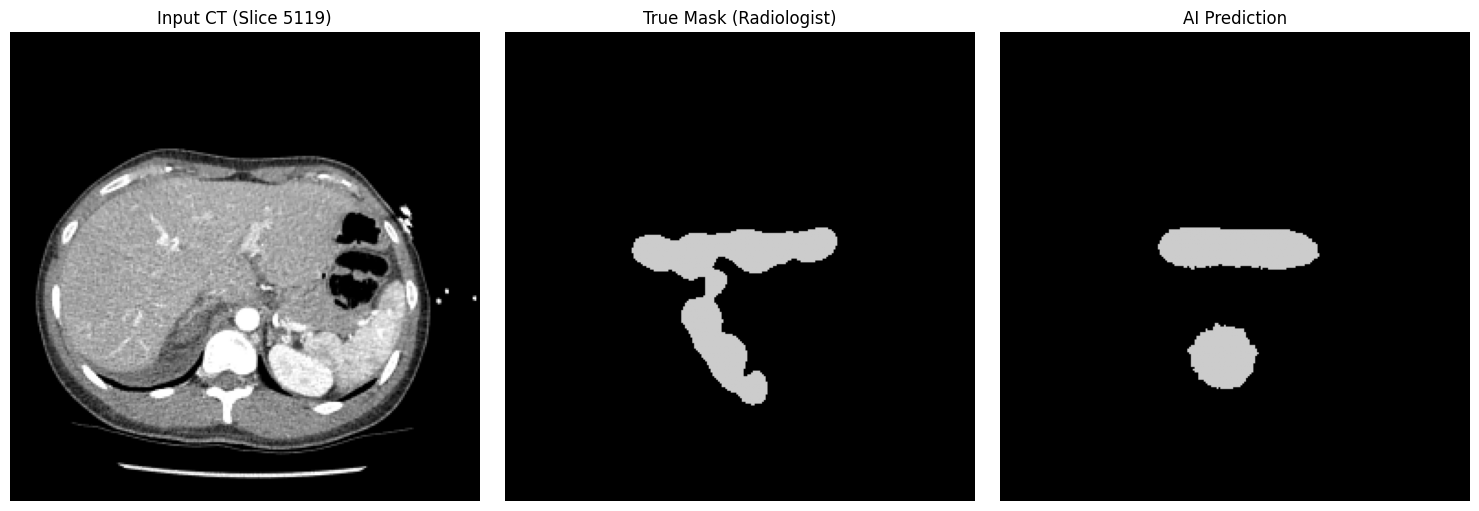

In [ ]:
import random

# Number of samples to visualize
N_SAMPLES = 5

print(f"🔎 Visualizing {N_SAMPLES} random validation samples...")

# Switch to eval mode
model.eval()

# Pick random indices
indices = random.sample(range(len(valid_ds)), N_SAMPLES)

for idx in indices:
    img_t, mask_t = valid_ds[idx]

    # Run Prediction
    with torch.no_grad():
        input_t = img_t.unsqueeze(0).to(EVAL_CONFIG['DEVICE'])
        logits = model(input_t)
        pred_mask = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()

    # Prepare data for plotting
    img_np = img_t[1, :, :].numpy() # Middle channel
    mask_np = mask_t.numpy()

    # Plot
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # 1. Input Image
    ax[0].imshow(img_np, cmap='gray')
    ax[0].set_title(f"Input CT (Slice {idx})")
    ax[0].axis('off')

    # 2. Ground Truth
    ax[1].imshow(mask_np, cmap='nipy_spectral', vmin=0, vmax=5)
    ax[1].set_title("True Mask (Radiologist)")
    ax[1].axis('off')

    # 3. Model Prediction
    ax[2].imshow(pred_mask, cmap='nipy_spectral', vmin=0, vmax=5)
    ax[2].set_title("AI Prediction")
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()

⏳ Gathering data from 200 random validation slices...


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

✅ Data gathered. Generating plots...


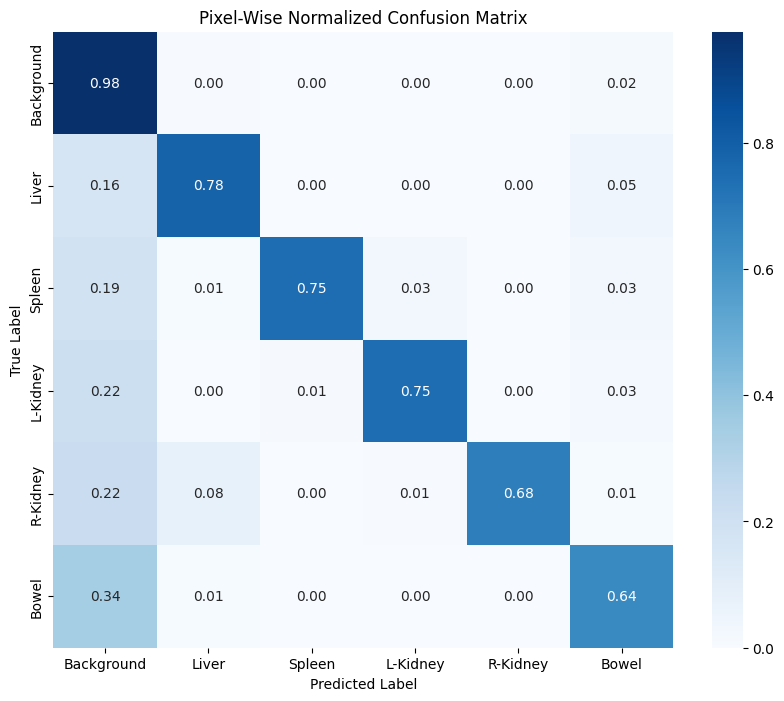

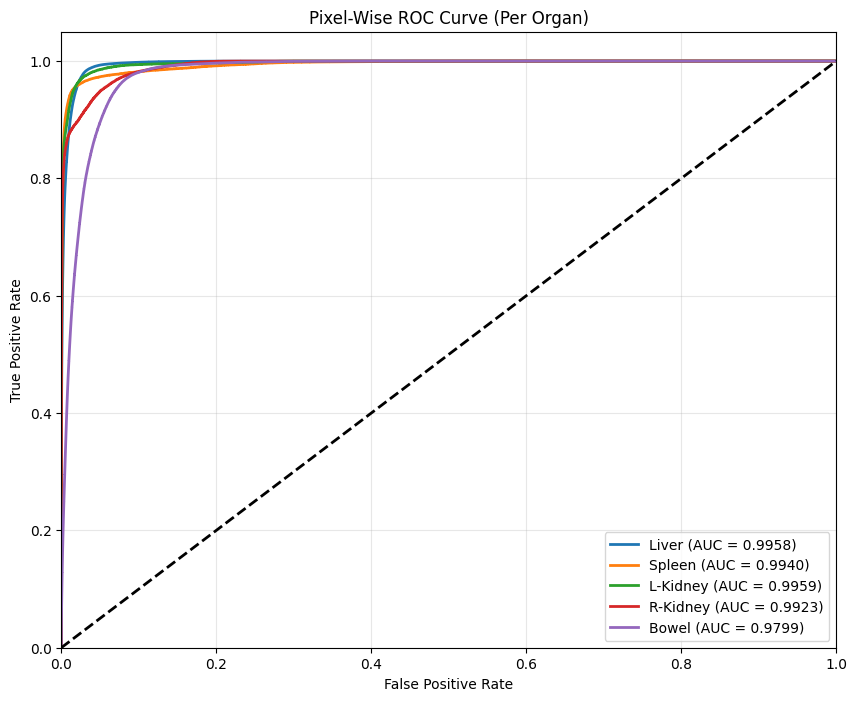

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tqdm.notebook import tqdm
import random

# ==========================================
# 1. CONFIGURATION
# ==========================================
EVAL_CONFIG = {
    "MODEL_PATH": "best_mobilenet_rsna_refined.pth", # Your best model
    "DEVICE": "cuda",
    "NUM_CLASSES": 6,
    "LABELS": ["Background", "Liver", "Spleen", "L-Kidney", "R-Kidney", "Bowel"],
    "SAMPLE_SIZE": 200 # Number of slices to use for plotting (prevents RAM crash)
}

# ==========================================
# 2. DATA GATHERING
# ==========================================
print(f"⏳ Gathering data from {EVAL_CONFIG['SAMPLE_SIZE']} random validation slices...")

# Containers for flattened pixel data
y_true_all = []
y_pred_all = []
y_prob_all = []

# Randomly select a subset of the validation loader to save time/memory
# (We assume 'valid_ds' is already defined from previous cells)
indices = random.sample(range(len(valid_ds)), EVAL_CONFIG['SAMPLE_SIZE'])
subset_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(valid_ds, indices),
    batch_size=32,
    shuffle=False,
    num_workers=2
)

model.eval()

with torch.no_grad():
    for images, masks in tqdm(subset_loader, desc="Processing"):
        images = images.to(EVAL_CONFIG['DEVICE'])

        # Get Model Outputs
        logits = model(images)

        # 1. Get Softmax Probabilities (For ROC)
        probs = torch.softmax(logits, dim=1) # Shape: (B, C, H, W)

        # 2. Get Hard Predictions (For Confusion Matrix)
        preds = torch.argmax(logits, dim=1)  # Shape: (B, H, W)

        # Move to CPU and Flatten
        # We perform permutation to get channels last before flattening for ROC
        probs_np = probs.permute(0, 2, 3, 1).reshape(-1, EVAL_CONFIG['NUM_CLASSES']).cpu().numpy()
        preds_np = preds.view(-1).cpu().numpy()
        masks_np = masks.view(-1).numpy()

        # Filter out background pixels ONLY IF you want to focus on organs
        # For now, we keep everything to see false positives

        y_true_all.append(masks_np)
        y_pred_all.append(preds_np)
        y_prob_all.append(probs_np)

# Concatenate all batches
y_true = np.concatenate(y_true_all)
y_pred = np.concatenate(y_pred_all)
y_prob = np.concatenate(y_prob_all)

print("✅ Data gathered. Generating plots...")

# ==========================================
# 3. CONFUSION MATRIX
# ==========================================
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, normalize='true') # Normalize rows (Recall)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Pixel-Wise Normalized Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_true, y_pred, EVAL_CONFIG['LABELS'])

# ==========================================
# 4. MULTI-CLASS ROC CURVE
# ==========================================
def plot_multiclass_roc(y_true, y_prob, n_classes, labels):
    # Binarize the true labels for ROC calculation
    y_true_bin = label_binarize(y_true, classes=range(n_classes))

    plt.figure(figsize=(10, 8))

    # Plot curve for each class
    for i in range(1, n_classes): # Start from 1 to skip Background (it dominates the graph)
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{labels[i]} (AUC = {roc_auc:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Pixel-Wise ROC Curve (Per Organ)')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

plot_multiclass_roc(y_true, y_prob, EVAL_CONFIG['NUM_CLASSES'], EVAL_CONFIG['LABELS'])